In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel, ExpSineSquared, DotProduct, RationalQuadratic
from matplotlib import pyplot as plt

In [2]:
def plot_gp(x_pred, y_pred, sigmas, x_train, y_train, true_y=None, samples=None, ax=None, legendon=True):
    """
    Function that plots the GP mean & std on top of given points.
    x_pred: points for prediction
    y_pred: means
    sigmas: std
    x, y: given data
    true_y: 
    samples: 2D numpy array with shape (# of points, # of samples)
    """
    if samples is not None:
        ax.plot(x_pred.reshape(-1, 1), samples)
    
    ax.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0, 
                 ecolor=(0.65, 0.65, 0.65), fmt = "r-", 
                 label="pred mean")
    ax.plot(x_train, y_train, "ko", label="training set")
    if true_y is not None:
        ax.plot(x_pred, true_y, "b-", label="ground truth")
    if legendon: ax.legend()

## Taxi Data

In [3]:
# Loading Taxi Dataset (fhv / hvfhv / yellow / green / allsum)
fhv = pd.read_csv("https://raw.githubusercontent.com/sujeongcha/TimeSeries-Transporation-and-Covid19/main/Data/Taxi_Data/full_fhv.csv")
hvfhv = pd.read_csv("https://raw.githubusercontent.com/sujeongcha/TimeSeries-Transporation-and-Covid19/main/Data/Taxi_Data/full_hvfhv.csv")
yellow = pd.read_csv("https://raw.githubusercontent.com/sujeongcha/TimeSeries-Transporation-and-Covid19/main/Data/Taxi_Data/full_yellow.csv")
green = pd.read_csv("https://raw.githubusercontent.com/sujeongcha/TimeSeries-Transporation-and-Covid19/main/Data/Taxi_Data/full_green.csv")
taxi = pd.read_csv("https://raw.githubusercontent.com/sujeongcha/TimeSeries-Transporation-and-Covid19/main/Data/Taxi_Data/full_taxi_types.csv")

# converting pickup_datetime to datetime object
for df in [fhv, hvfhv, yellow, green, taxi]:
    df.pickup_datetime = pd.to_datetime(df.pickup_datetime)
print("Checking datatype:\n")
print(taxi.info())

# groupby datetime
fhv = fhv.groupby(['pickup_datetime']).sum()
hvfhv = hvfhv.groupby(['pickup_datetime']).sum()
yellow = yellow.groupby(['pickup_datetime']).sum()
green = green.groupby(['pickup_datetime']).sum()
taxi = taxi.groupby(['pickup_datetime']).sum()
print("\nChecking groupby:\n")
print(taxi.head(5))

Checking datatype:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33923 entries, 0 to 33922
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   pickup_datetime  33923 non-null  datetime64[ns]
 1   Borough          33923 non-null  object        
 2   passenger_count  33923 non-null  int64         
 3   trip_distance    32867 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 1.0+ MB
None

Checking groupby:

                 passenger_count  trip_distance
pickup_datetime                                
2015-01-01                860105       6.458856
2015-01-02                728493      40.499140
2015-01-03                879888      19.506015
2015-01-04                686645      25.238159
2015-01-05                729239       6.060544


In [4]:
old = yellow.append(green).groupby(['pickup_datetime']).sum()
new = fhv.append(hvfhv).groupby(['pickup_datetime']).sum()

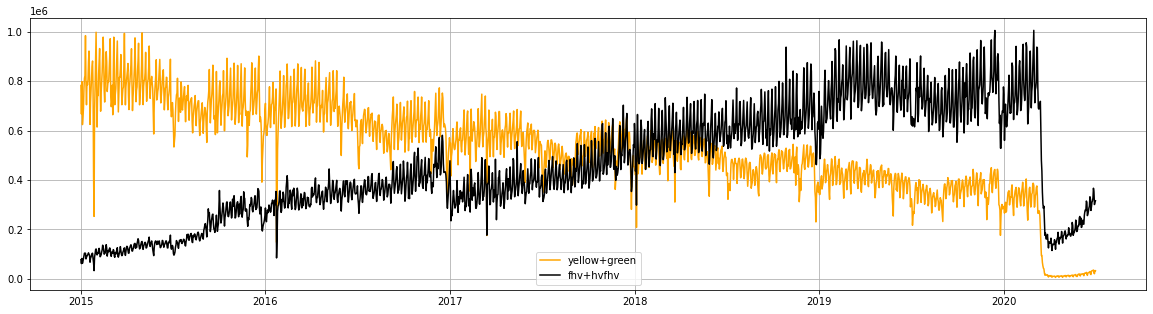

In [5]:
plt.figure(figsize=(20,5))
plt.plot(old.passenger_count, color='orange', label="yellow+green")
plt.plot(new.passenger_count, color='black', label="fhv+hvfhv")
plt.legend()
plt.grid()
plt.show()

In [6]:
# preCovid // postCovid
old = old.groupby(old.index).sum()
new = new.groupby(new.index).sum()
old_preCovid = old.loc[:'2020-02-29']
new_preCovid = new.loc[:'2020-02-29']
old_postCovid = old.loc['2020-03-01':]
new_postCovid = new.loc['2020-03-01':]

In [7]:
# train / test
old_train = old_preCovid[:'2019-10-31']
new_train = new_preCovid[:'2019-10-31']
old_test = old_preCovid['2019-11-01':]
new_test = new_preCovid['2019-11-01':]

In [8]:
# normalization
import warnings
warnings.filterwarnings("ignore")

scaler = StandardScaler()
scaler.fit(old_train['passenger_count'].values.reshape(-1,1))
old_train['scaled_count'] = scaler.transform(old_train['passenger_count'].values.reshape(-1,1))
old_test['scaled_count'] = scaler.transform(old_test['passenger_count'].values.reshape(-1,1))
old_postCovid['scaled_count'] = scaler.transform(old_postCovid['passenger_count'].values.reshape(-1,1))

scaler = StandardScaler()
scaler.fit(new_train['passenger_count'].values.reshape(-1,1))
new_train['scaled_count'] = scaler.transform(new_train['passenger_count'].values.reshape(-1,1))
new_test['scaled_count'] = scaler.transform(new_test['passenger_count'].values.reshape(-1,1))
new_postCovid['scaled_count'] = scaler.transform(new_postCovid['passenger_count'].values.reshape(-1,1))

### Traditional Taxi (yellow + green)

In [9]:
traintime = np.arange(len(old_train))
predtime = np.arange(len(old))
true_y = pd.concat([old_train, old_test, old_postCovid])['scaled_count']

kernel = RBF() + ExpSineSquared(periodicity=7)*DotProduct() + ConstantKernel(constant_value=1)
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(traintime.reshape(-1,1), old_train['scaled_count'].values.reshape(-1,1))
mus, sigmas = gp.predict(predtime.reshape(-1,1), return_std=True)

train mse = 4.63896029556133e-13


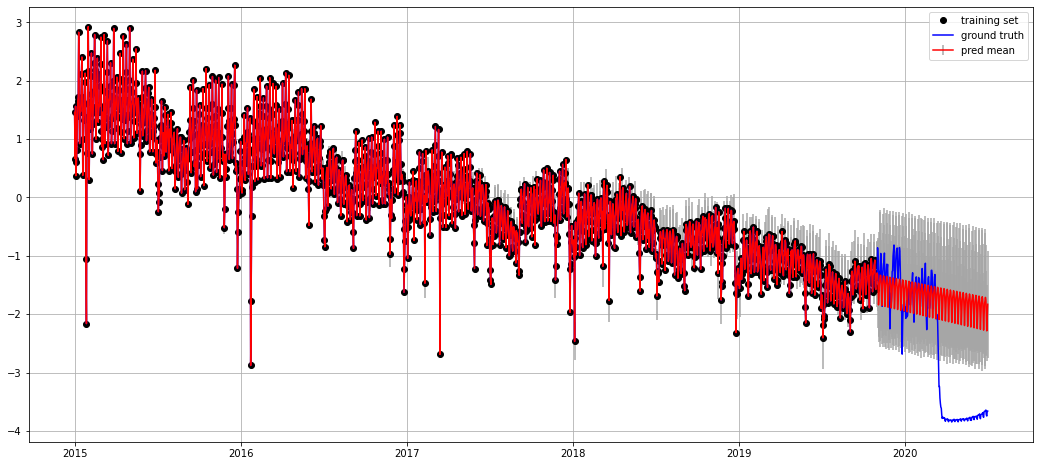

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
plot_gp(old.index, mus, sigmas, old_train.index, old_train['scaled_count'], true_y, ax=ax)
plt.grid()
print("train mse = {0}".format((mean_squared_error(mus[:len(old_train)], true_y[:len(old_train)]))))

test mse = 0.102869922587452


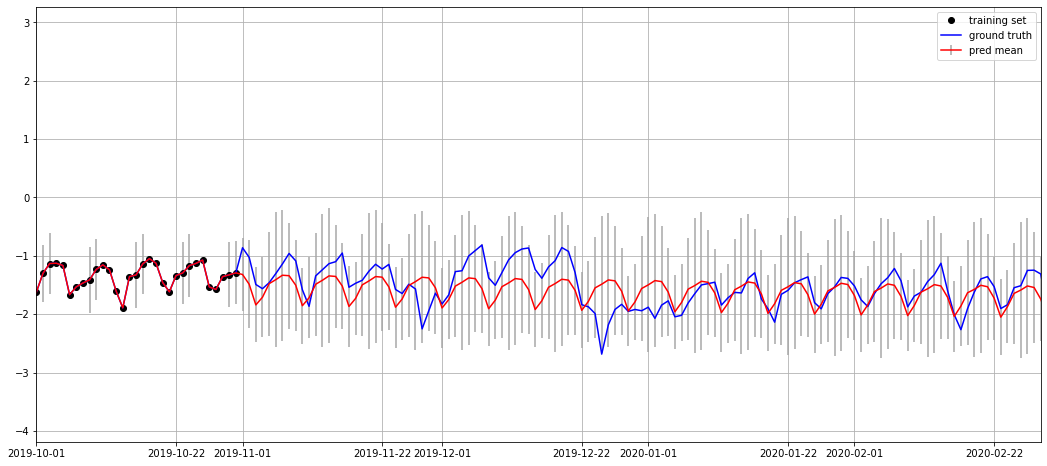

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
plot_gp(old.index, mus, sigmas, old_train.index, old_train['scaled_count'], true_y, ax=ax)
plt.xlim('2019-10-01', '2020-02-29')
plt.grid()
print("test mse = {0}".format((mean_squared_error(mus[len(old_train):len(old_train)+len(old_test)], \
                                                  true_y[len(old_train):len(old_train)+len(old_test)]))))

postCovid mse = 3.347532411409032


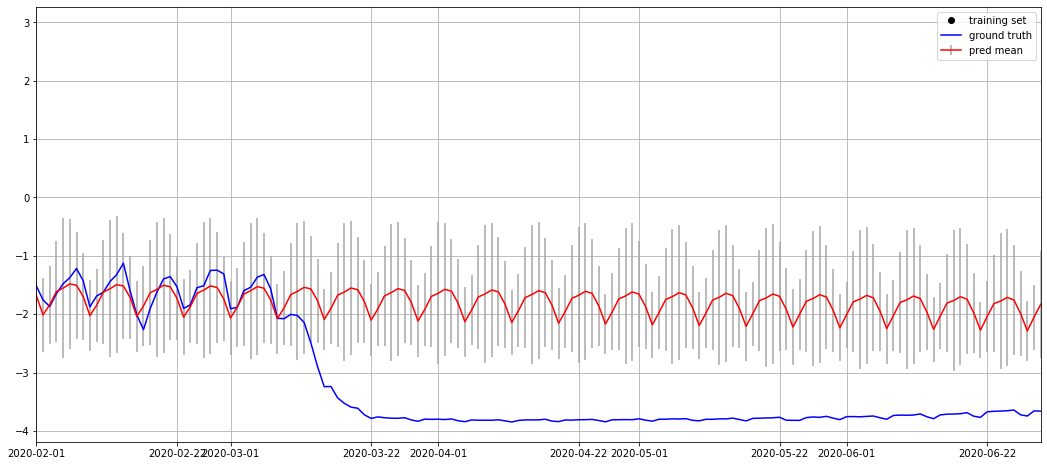

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
plot_gp(old.index, mus, sigmas, old_train.index, old_train['scaled_count'], true_y, ax=ax)
plt.xlim('2020-02-01', '2020-06-30')
plt.grid()
print("postCovid mse = {0}".format((mean_squared_error(mus[-len(old_postCovid):], true_y[-len(old_postCovid):]))))

### For-hire Vehicles (Uber, Lyft)

In [13]:
traintime = np.arange(len(new_train))
predtime = np.arange(len(new))
true_y = pd.concat([new_train, new_test, new_postCovid])['scaled_count']

kernel = RBF() + ExpSineSquared(periodicity=7)*DotProduct() + ConstantKernel(constant_value=1)
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(traintime.reshape(-1,1), new_train['scaled_count'].values.reshape(-1,1))
mus, sigmas = gp.predict(predtime.reshape(-1,1), return_std=True)

train mse = 2.27317493730182e-13


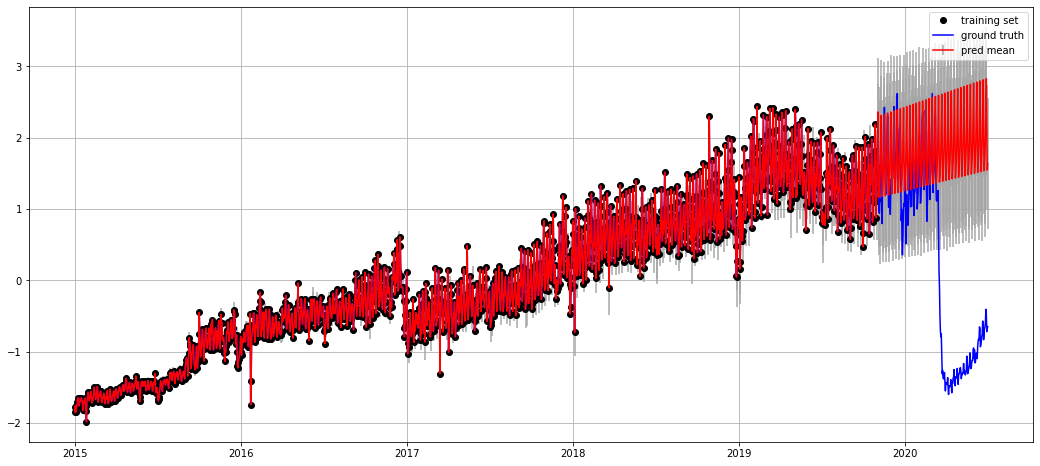

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
plot_gp(new.index, mus, sigmas, new_train.index, new_train['scaled_count'], true_y, ax=ax)
plt.grid()
print("train mse = {0}".format((mean_squared_error(mus[:len(new_train)], true_y[:len(new_train)]))))

test mse = 0.19756187131063987


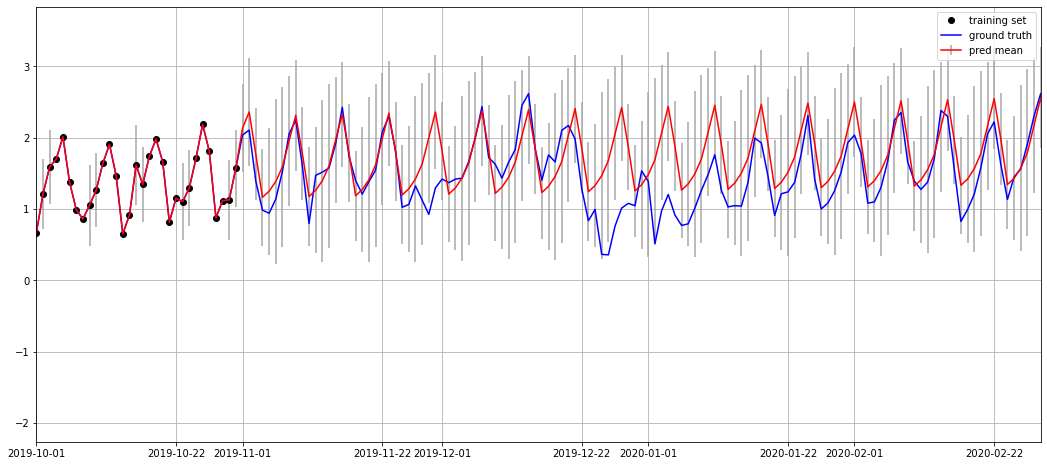

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
plot_gp(new.index, mus, sigmas, new_train.index, new_train['scaled_count'], true_y, ax=ax)
plt.xlim('2019-10-01', '2020-02-29')
plt.grid()
print("test mse = {0}".format((mean_squared_error(mus[len(new_train):len(new_train)+len(new_test)], \
                                                  true_y[len(new_train):len(new_train)+len(new_test)]))))

postCovid mse = 8.710223087210595


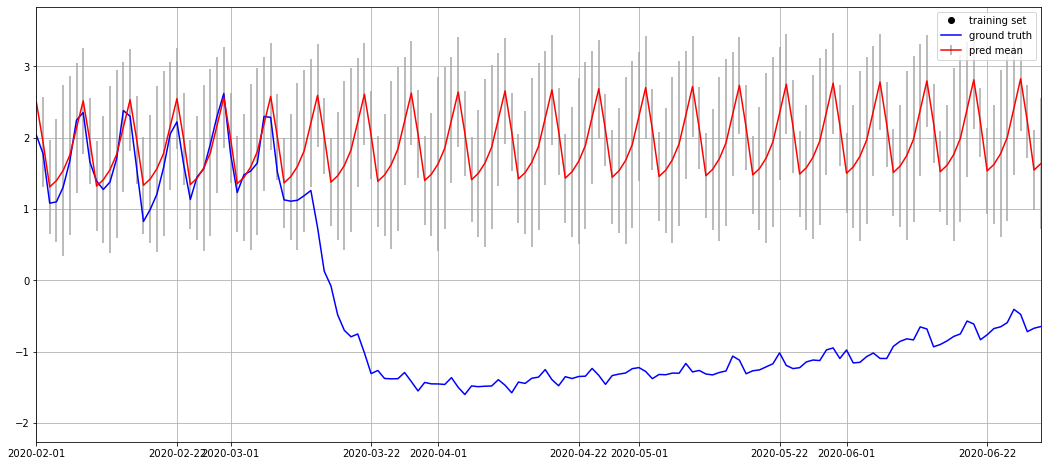

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
plot_gp(new.index, mus, sigmas, new_train.index, new_train['scaled_count'], true_y, ax=ax)
plt.xlim('2020-02-01', '2020-06-30')
plt.grid()
print("postCovid mse = {0}".format((mean_squared_error(mus[-len(new_postCovid):], true_y[-len(new_postCovid):]))))

## Subway Data

In [17]:
train = pd.read_csv("https://raw.githubusercontent.com/sujeongcha/TimeSeries-Transporation-and-Covid19/main/Data/Subway_Data/preCovid_stdized_train.csv")
test = pd.read_csv("https://raw.githubusercontent.com/sujeongcha/TimeSeries-Transporation-and-Covid19/main/Data/Subway_Data/preCovid_stdized_test.csv")
postCovid = pd.read_csv("https://raw.githubusercontent.com/sujeongcha/TimeSeries-Transporation-and-Covid19/main/Data/Subway_Data/postCovid_stdized.csv")

In [18]:
for df in [train, test, postCovid]:
    df.date = pd.to_datetime(df.date)

In [19]:
train = train.set_index('date')
test = test.set_index('date')
postCovid = postCovid.set_index('date')

In [20]:
total = pd.concat([train, test, postCovid])

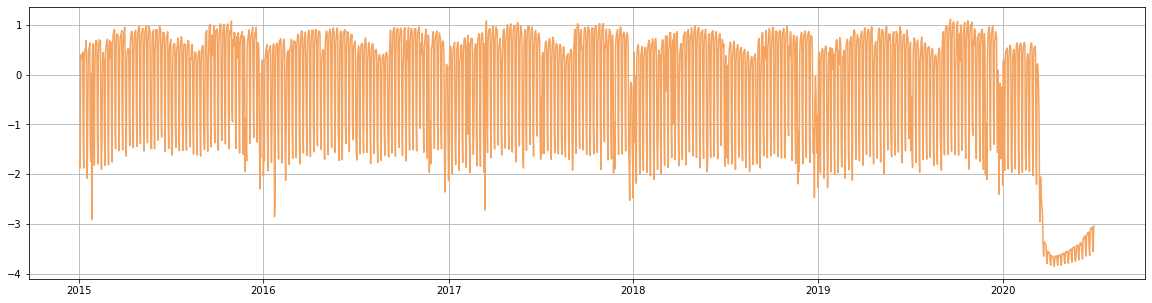

In [21]:
plt.figure(figsize=(20,5))
plt.plot(total['entries_scaled'], color='sandybrown')
plt.grid()
plt.show()

In [22]:
traintime = np.arange(len(train))
predtime = np.arange(len(train)+len(test)+len(postCovid))
true_y = pd.concat([train, test, postCovid])['entries_scaled']

kernel = RBF() + ExpSineSquared(periodicity=7)*DotProduct() + ConstantKernel(constant_value=1)
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(traintime.reshape(-1,1), train['entries_scaled'].values.reshape(-1,1))
mus, sigmas = gp.predict(predtime.reshape(-1,1), return_std=True)

train mse = 9.695989317352703e-13


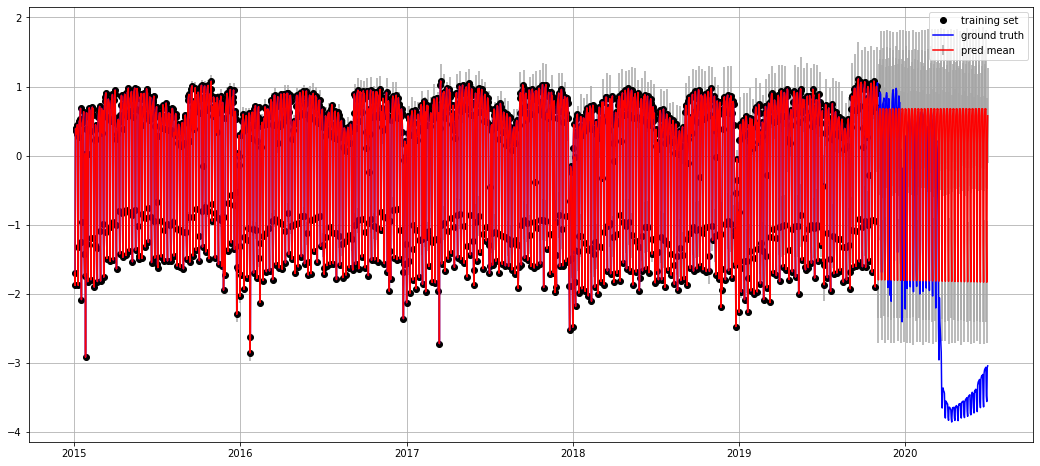

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
plot_gp(total.index, mus, sigmas, train.index, train['entries_scaled'], true_y, ax=ax)
plt.grid()
print("train mse = {0}".format((mean_squared_error(mus[:len(train)], true_y[:len(train)]))))

test mse = 0.35000534381305803


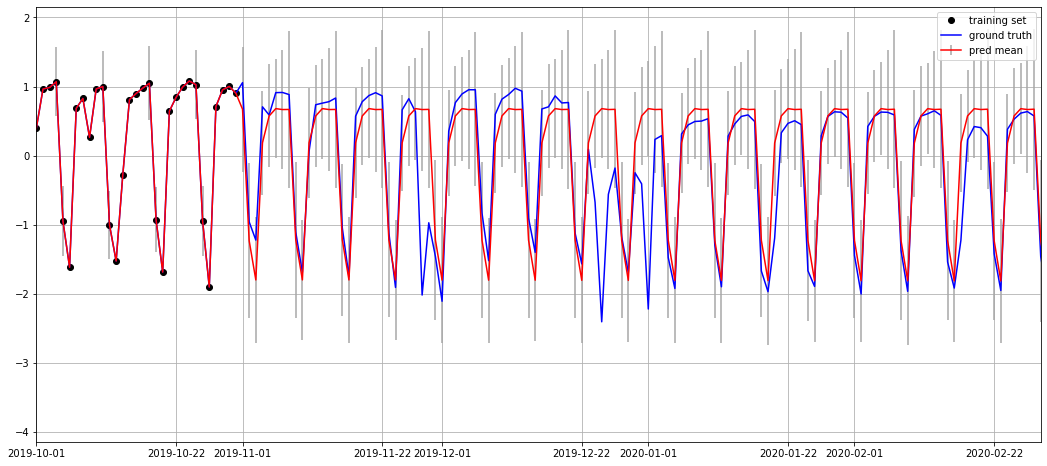

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
plot_gp(total.index, mus, sigmas, train.index, train['entries_scaled'], true_y, ax=ax)
plt.xlim('2019-10-01', '2020-02-29')
plt.grid()
print("test mse = {0}".format((mean_squared_error(mus[len(train):len(train)+len(test)], \
                                                  true_y[len(train):len(train)+len(test)]))))

postCovid mse = 11.156952578289815


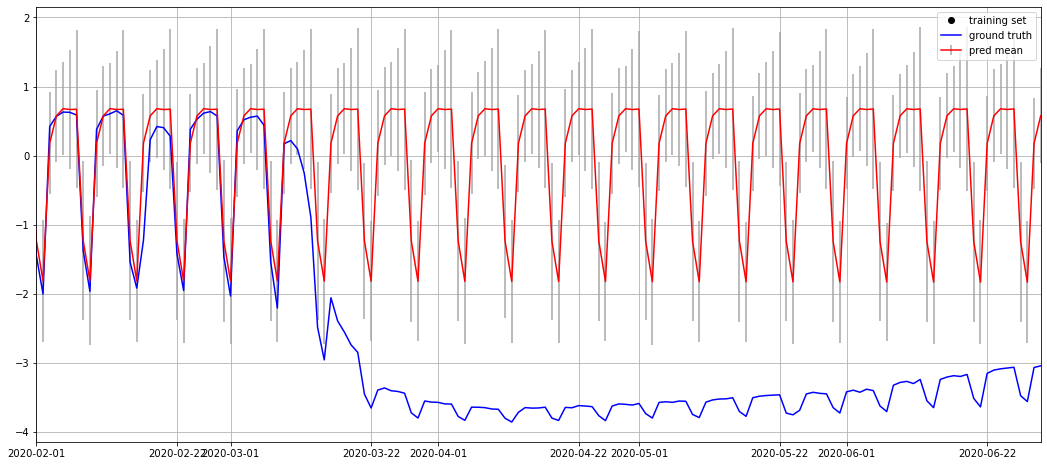

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
plot_gp(total.index, mus, sigmas, train.index, train['entries_scaled'], true_y, ax=ax)
plt.xlim('2020-02-01', '2020-06-30')
plt.grid()
print("postCovid mse = {0}".format((mean_squared_error(mus[-len(postCovid):], true_y[-len(postCovid):]))))

## CitiBike Data

In [26]:
bike = pd.read_csv("https://raw.githubusercontent.com/sujeongcha/TimeSeries-Transporation-and-Covid19/main/Data/CitiBike_Data/citibike_1520.csv", index_col=0)
bike.starttime_day = pd.to_datetime(bike.starttime_day)
bike = bike.set_index('starttime_day')

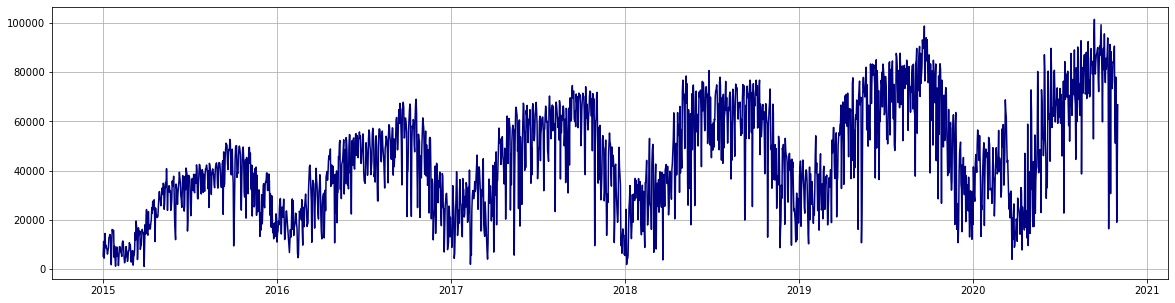

In [27]:
plt.figure(figsize=(20,5))
plt.plot(bike.usertype, color='navy')
plt.grid()
plt.show()

In [28]:
# preCovid // postCovid
preCovid = bike.loc[:'2020-02-29']
postCovid = bike.loc['2020-03-01':'2020-06-30']

# train / test
train = preCovid[:'2019-10-31']
test = preCovid['2019-11-01':]

In [29]:
scaler = StandardScaler()
scaler.fit(train['usertype'].values.reshape(-1,1))
train['scaled_count'] = scaler.transform(train['usertype'].values.reshape(-1,1))
test['scaled_count'] = scaler.transform(test['usertype'].values.reshape(-1,1))
postCovid['scaled_count'] = scaler.transform(postCovid['usertype'].values.reshape(-1,1))

In [79]:
traintime = np.arange(len(train))
true_y = pd.concat([train, test, postCovid])['scaled_count']
predtime = np.arange(len(true_y))

# kernel = RBF(length_scale=0.3) + ExpSineSquared(periodicity=365)*DotProduct() + ConstantKernel(constant_value=1)
kernel = RBF(length_scale=4) + ExpSineSquared(periodicity=365)*DotProduct() + ConstantKernel(constant_value=1) + \
        RationalQuadratic(length_scale=0.3)
gp = gaussian_process.GaussianProcessRegressor(kernel=kernel)
gp.fit(traintime.reshape(-1,1), train['scaled_count'].values.reshape(-1,1))
mus, sigmas = gp.predict(predtime.reshape(-1,1), return_std=True)

train mse = 7.417096359897368e-17


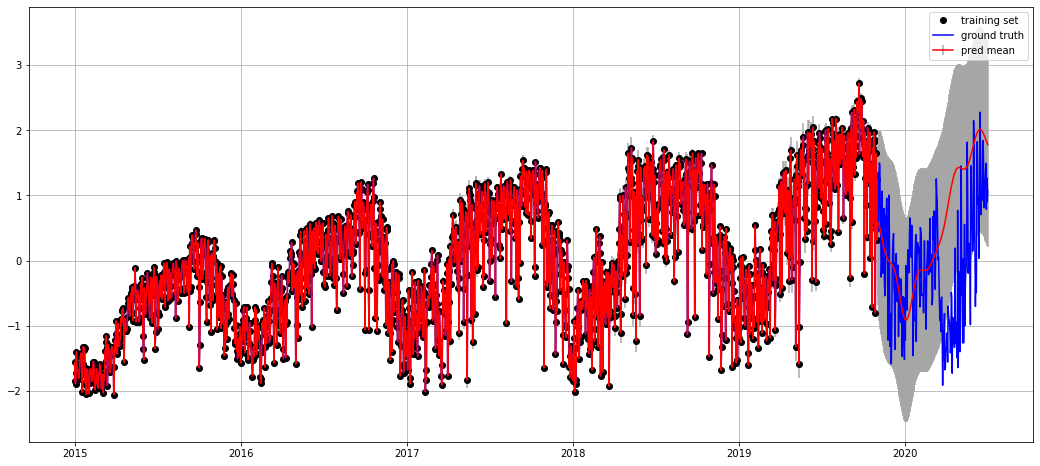

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
plot_gp(true_y.index, mus, sigmas, train.index, train['scaled_count'], true_y, ax=ax)
plt.grid()
print("train mse = {0}".format((mean_squared_error(mus[:len(train)], true_y[:len(train)]))))

test mse = 0.36358133775160645


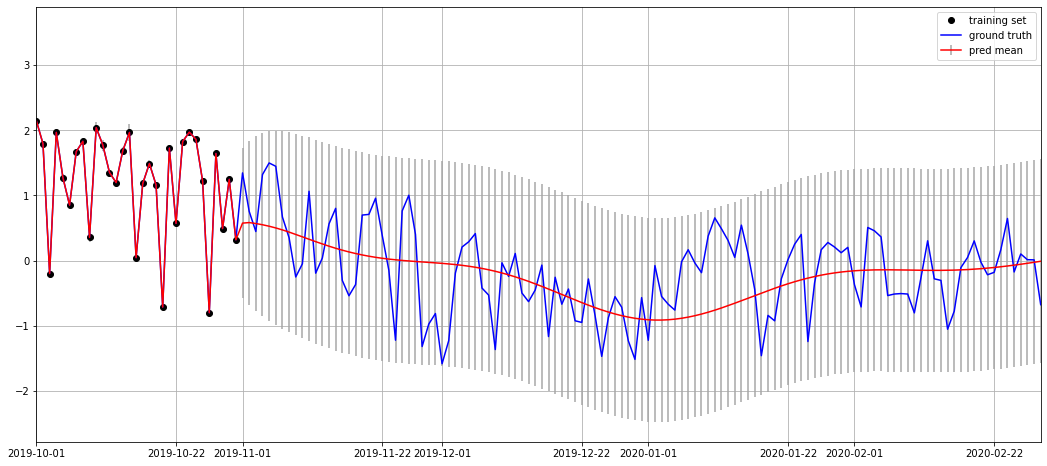

In [81]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
plot_gp(true_y.index, mus, sigmas, train.index, train['scaled_count'], true_y, ax=ax)
plt.xlim('2019-10-01', '2020-02-29')
plt.grid()
print("test mse = {0}".format((mean_squared_error(mus[len(train):len(train)+len(test)], \
                                                  true_y[len(train):len(train)+len(test)]))))

postCovid mse = 2.6035948037103527


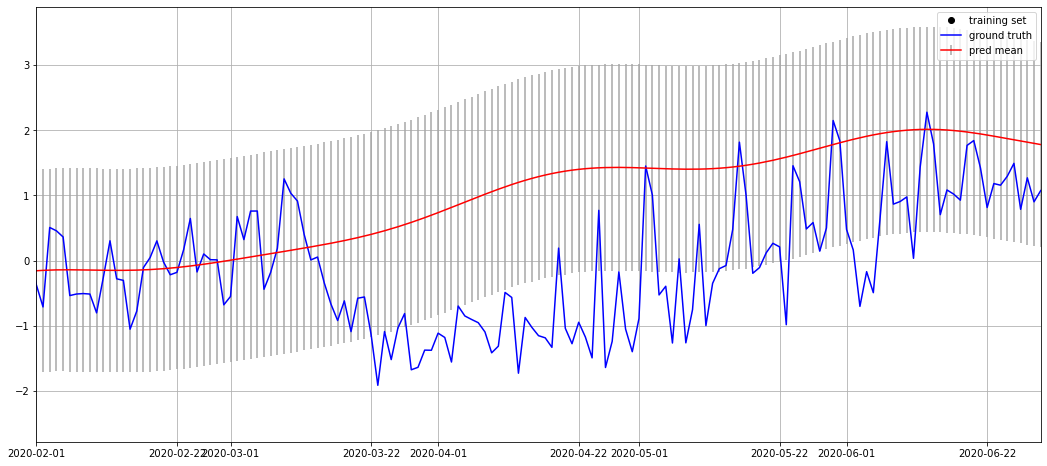

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(18,8))
plot_gp(true_y.index, mus, sigmas, train.index, train['scaled_count'], true_y, ax=ax)
plt.xlim('2020-02-01', '2020-06-30')
plt.grid()
print("postCovid mse = {0}".format((mean_squared_error(mus[-len(postCovid):], true_y[-len(postCovid):]))))